## GAN (Generative Adversarial Network)

Differently with CV04-1, we will now use convolutional networks, instead of all FCs.

I will no longer use Google Colab but use Kaggle or my local gpu device.
(Kaggle seems to provide explicit GPU Quota, rather than Colab.)

### Prepare fashion MNIST dataset

In [1]:
import numpy as np

from tensorflow.keras.datasets import fashion_mnist


(x_train, y_train), _ = fashion_mnist.load_data()

# select images of specific object; 1 = trousers
y_class = 1
x_train = x_train[np.where(y_train == y_class)[0]]

# normalize to [0, 1]
x_train = np.float32(x_train) / 255.0

# add last dim
x_train = np.expand_dims(x_train, -1)

4423680/4422102 [==============================] - 0s 0us/step


In [2]:
print(x_train[0].shape)

(28, 28, 1)


### Build Generator

We will set latent space as R^100.

In [3]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Reshape, Flatten, Dense, Conv2D, \
  Conv2DTranspose, LeakyReLU, BatchNormalization, Dropout


def build_generator():
  """
  latent vector (100,) => image (28, 28)
  apply sigmoid on last activation, cause we normalized the x_train.
  """

  def conv_t_block(x, filters, kernel=3, strides=2):
    x = Conv2DTranspose(filters, kernel, padding='same', strides=strides,
                        activation='relu', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    return x

  i = Input(shape=(100,))

  x = Dense(7*7*256, activation='relu', kernel_initializer='he_normal')(i)
  x = Reshape((7, 7, 256))(x)         #  7,  7, 256
  x = conv_t_block(x, 128)            # 14, 14, 128
  x = conv_t_block(x, 128)            # 28, 28, 128

  x = Conv2DTranspose(1, 3, padding='same', activation='sigmoid')(x) # 28, 28, 1
  return Model(inputs=i, outputs=x)

gen = build_generator()
gen.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense (Dense)                (None, 12544)             1266944   
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 128)       295040    
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 128)       512       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 128)       147584    
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 128)      

### Build Discriminator

In [4]:
def build_discriminator():
  """
  image (28, 28) => 0 or 1
  """

  def conv_block(x, filters, kernel=3):
    x = Conv2D(filters, kernel, padding='same', strides=2,
               activation='relu', kernel_initializer='he_normal')(x)
    return x

  i = Input(shape=(28, 28, 1))
  
  x = conv_block(i, 128)
  x = conv_block(x, 256)

  x = Flatten()(x)

  x = Dense(256, activation='relu', kernel_initializer='he_normal')(x)
  x = Dense(128, activation='relu', kernel_initializer='he_normal')(x)
  x = Dense(1, activation='sigmoid')(x)

  return Model(inputs=i, outputs=x)

dis = build_discriminator()
dis.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 128)       1280      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 256)         295168    
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               3211520   
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

### Compile model

Note that discriminator trainable is set to False, after `compile` of discriminator.

In [5]:
dis.compile(optimizer='adam', loss='binary_crossentropy')
dis.trainable = False

gen_dis = Sequential([gen, dis])
gen_dis.summary()

gen_dis.compile(optimizer='adam', loss='binary_crossentropy')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
functional_1 (Functional)    (None, 28, 28, 1)         1711745   
_________________________________________________________________
functional_3 (Functional)    (None, 1)                 3540993   
Total params: 5,252,738
Trainable params: 1,711,233
Non-trainable params: 3,541,505
_________________________________________________________________


### Train G-D

0 epoch / 150 epochs
188/188 [==============================] - 1s 3ms/step - loss: 0.6393


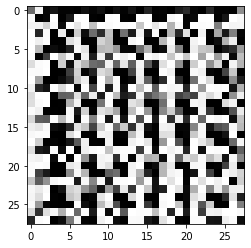

1 epoch / 150 epochs
188/188 [==============================] - 1s 3ms/step - loss: 0.5060
2 epoch / 150 epochs
188/188 [==============================] - 1s 4ms/step - loss: 0.1631
3 epoch / 150 epochs
188/188 [==============================] - 1s 3ms/step - loss: 0.1576
4 epoch / 150 epochs
188/188 [==============================] - 1s 3ms/step - loss: 0.0550
5 epoch / 150 epochs
188/188 [==============================] - 1s 3ms/step - loss: 0.0011
6 epoch / 150 epochs
188/188 [==============================] - 1s 4ms/step - loss: 0.0107
7 epoch / 150 epochs
188/188 [==============================] - 1s 3ms/step - loss: 0.1709
8 epoch / 150 epochs
188/188 [==============================] - 1s 4ms/step - loss: 0.0649
9 epoch / 150 epochs
188/188 [==============================] - 1s 5ms/step - loss: 0.3323
10 epoch / 150 epochs
188/188 [==============================] - 1s 3ms/step - loss: 0.0188
11 epoch / 150 epochs
188/188 [==============================] - 1s 3ms/step - loss: 0.00

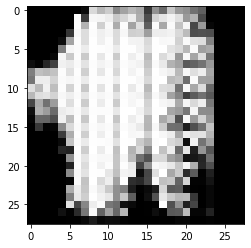

31 epoch / 150 epochs
188/188 [==============================] - 1s 3ms/step - loss: 0.0261
32 epoch / 150 epochs
188/188 [==============================] - 1s 3ms/step - loss: 0.0407
33 epoch / 150 epochs
188/188 [==============================] - 1s 3ms/step - loss: 0.0208
34 epoch / 150 epochs
188/188 [==============================] - 1s 4ms/step - loss: 0.0124
35 epoch / 150 epochs
188/188 [==============================] - 1s 3ms/step - loss: 0.1389
36 epoch / 150 epochs
188/188 [==============================] - 1s 3ms/step - loss: 0.2613
37 epoch / 150 epochs
188/188 [==============================] - 1s 3ms/step - loss: 0.1657
38 epoch / 150 epochs
188/188 [==============================] - 1s 3ms/step - loss: 0.0013
39 epoch / 150 epochs
188/188 [==============================] - 1s 3ms/step - loss: 0.1816
40 epoch / 150 epochs
188/188 [==============================] - 1s 3ms/step - loss: 0.0163
41 epoch / 150 epochs
188/188 [==============================] - 1s 4ms/step - l

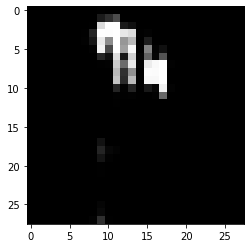

61 epoch / 150 epochs
188/188 [==============================] - 1s 3ms/step - loss: 0.1362
62 epoch / 150 epochs
188/188 [==============================] - 1s 3ms/step - loss: 0.0728
63 epoch / 150 epochs
188/188 [==============================] - 1s 3ms/step - loss: 0.1581
64 epoch / 150 epochs
188/188 [==============================] - 1s 4ms/step - loss: 0.3831
65 epoch / 150 epochs
188/188 [==============================] - 1s 4ms/step - loss: 0.3645
66 epoch / 150 epochs
188/188 [==============================] - 1s 3ms/step - loss: 0.3070
67 epoch / 150 epochs
188/188 [==============================] - 1s 3ms/step - loss: 0.2714
68 epoch / 150 epochs
188/188 [==============================] - 1s 3ms/step - loss: 0.1274
69 epoch / 150 epochs
188/188 [==============================] - 1s 4ms/step - loss: 0.0331
70 epoch / 150 epochs
188/188 [==============================] - 1s 3ms/step - loss: 0.0605
71 epoch / 150 epochs
188/188 [==============================] - 1s 3ms/step - l

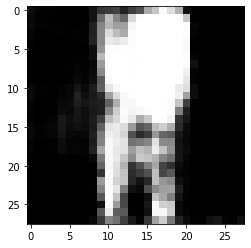

91 epoch / 150 epochs
188/188 [==============================] - 1s 3ms/step - loss: 0.3965
92 epoch / 150 epochs
188/188 [==============================] - 1s 3ms/step - loss: 0.3582
93 epoch / 150 epochs
188/188 [==============================] - 1s 3ms/step - loss: 0.3417
94 epoch / 150 epochs
188/188 [==============================] - 1s 3ms/step - loss: 0.2081
95 epoch / 150 epochs
188/188 [==============================] - 1s 4ms/step - loss: 0.1980
96 epoch / 150 epochs
188/188 [==============================] - 1s 3ms/step - loss: 0.3380
97 epoch / 150 epochs
188/188 [==============================] - 1s 4ms/step - loss: 0.2930
98 epoch / 150 epochs
188/188 [==============================] - 1s 3ms/step - loss: 0.2250
99 epoch / 150 epochs
188/188 [==============================] - 1s 3ms/step - loss: 0.2303
100 epoch / 150 epochs
188/188 [==============================] - 1s 3ms/step - loss: 0.3218
101 epoch / 150 epochs
188/188 [==============================] - 1s 3ms/step -

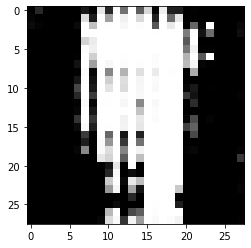

121 epoch / 150 epochs
188/188 [==============================] - 1s 3ms/step - loss: 0.3245
122 epoch / 150 epochs
188/188 [==============================] - 1s 3ms/step - loss: 0.1995
123 epoch / 150 epochs
188/188 [==============================] - 1s 4ms/step - loss: 0.0933
124 epoch / 150 epochs
188/188 [==============================] - 1s 3ms/step - loss: 0.0617
125 epoch / 150 epochs
188/188 [==============================] - 1s 4ms/step - loss: 0.0113
126 epoch / 150 epochs
188/188 [==============================] - 1s 3ms/step - loss: 0.1007
127 epoch / 150 epochs
188/188 [==============================] - 1s 3ms/step - loss: 0.0574
128 epoch / 150 epochs
188/188 [==============================] - 1s 3ms/step - loss: 0.1127
129 epoch / 150 epochs
188/188 [==============================] - 1s 3ms/step - loss: 0.0385
130 epoch / 150 epochs
188/188 [==============================] - 1s 3ms/step - loss: 0.3422
131 epoch / 150 epochs
188/188 [==============================] - 1s 3

In [6]:
import matplotlib.pyplot as plt

epochs = 150
batch = x_train.shape[0]

gen_history = []
dis0_history = []
dis1_history = []

for epoch in range(epochs):
  print("%d epoch / %d epochs" % (epoch, epochs))

  latent = np.random.normal(0, 1, (batch, 100))
  h = gen_dis.fit(x=latent, y=np.ones(batch))
  gen_history.append(h.history['loss'])

  fake_imgs = gen.predict(latent)
  h = dis.fit(x=fake_imgs, y=np.zeros(batch))
  dis0_history.append(h.history['loss'])

  h = dis.fit(x=x_train, y=np.ones(batch))
  dis1_history.append(h.history['loss'])

  if epoch % 30 == 0:
    plt.imshow(fake_imgs[0, :, :, 0], cmap='gray')
    plt.show()

### Check Loss, compare two images

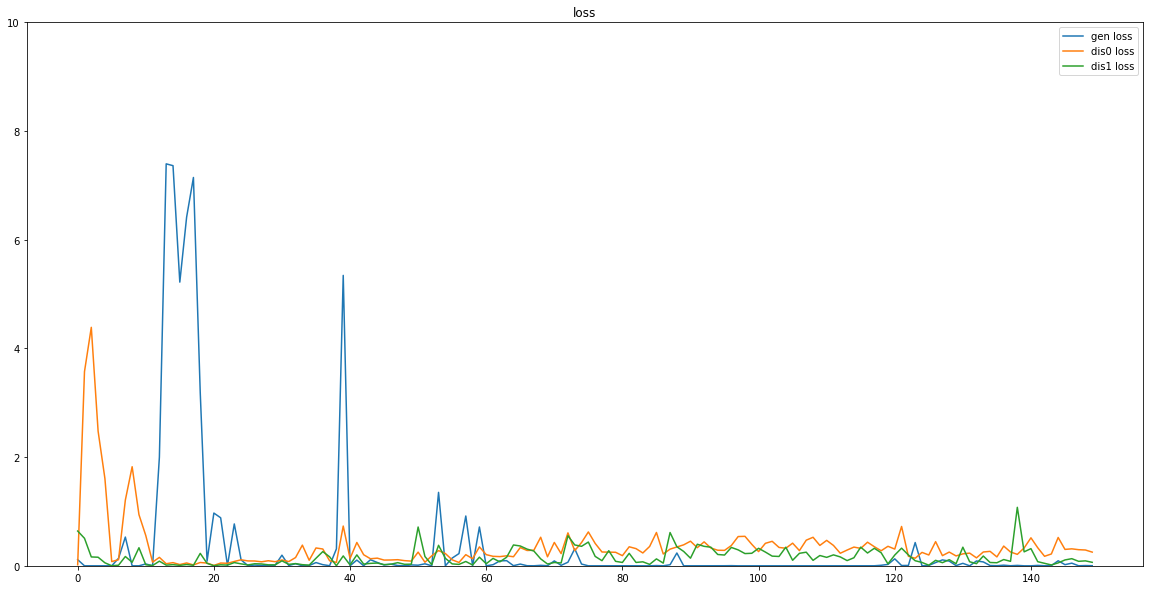

In [7]:
plt.figure(figsize=(20, 10))
plt.title('loss')

plt.ylim(0, 5)
plt.plot(gen_history, label='gen loss')
plt.plot(dis0_history, label='dis0 loss')
plt.plot(dis1_history, label='dis1 loss')

plt.legend()
plt.show()

<Figure size 432x288 with 0 Axes>

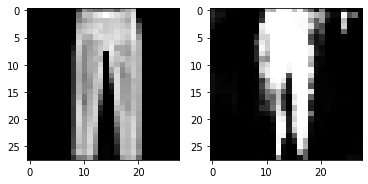

In [8]:
plt.figure()
plt.subplots(1, 2)

plt.subplot(1, 2, 1)
plt.imshow(x_train[0, :, :, 0], cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(fake_imgs[0, :, :, 0], cmap='gray')